In [ ]:
# ==============================================================================
# SCRIPT ANALISIS SPASIAL DAN KLASIFIKASI SPI-3 (3-BULANAN)
# STUDI KASUS: PROVINSI JAMBI
# Penulis: Jariyan Arifudin
# Data: CHIRPS v3 (Downscaled & Bias Corrected)
# ==============================================================================

## 1. IMPOR PUSTAKA & INSTALASI
import os

# Cek apakah rioxarray sudah ada, jika belum install
try:
    import rioxarray
except ImportError:
    print("Pustaka rioxarray tidak ditemukan. Menginstal...")
    !pip install rioxarray geopandas rasterio numpy scipy leafmap xarray matplotlib
    print("Instalasi selesai. Silakan Restart Runtime jika masih error.")
    import rioxarray

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rasterio
from rasterio import features
from rasterio.mask import geometry_mask
from shapely.geometry import shape
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google.colab import drive

# Instalasi paket tambahan (jika belum ada)
try:
    import leafmap
except ImportError:
    print("Menginstal pustaka geospasial...")
    !pip install rioxarray geopandas rasterio numpy scipy leafmap xarray matplotlib >> /dev/null

Pustaka rioxarray tidak ditemukan. Menginstal...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.8/662.8 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.5 MB/s eta 0:00:00
  Attemptin

In [ ]:
## 2. KONFIGURASI
# ------------------------------------------------------------------------------
# Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Path Direktori
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/Skripsi'
ADMIN_PATH = os.path.join(BASE_DIR, 'Batas Adm Jambi/Adm_Jambi_Prov.shp')
CHIRPS_DIR = os.path.join(BASE_DIR, 'CHIRPS v3/bias_corrected_regression/downscaled_1km_metric/')

# Folder Output Utama
OUTPUT_DIR = os.path.join(BASE_DIR, 'SPI3-Output/')

def load_boundary(path):
    """Memuat batas administrasi dan memastikannya dalam EPSG:4326."""
    gdf = gpd.read_file(path)
    return gdf.to_crs(epsg=4326)

def load_chirps(boundary, start_year, end_year):
    """Load, Reproject, dan Clip data CHIRPS."""
    datasets = []
    boundary = boundary.to_crs(epsg=4326)

    print(f">> Memuat data CHIRPS dari tahun {start_year} s.d {end_year}...")

    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            file_path = os.path.join(CHIRPS_DIR, f"chirps-v3.0.{year}.{month:02d}.1000m_metric.tif")

            if os.path.exists(file_path):
                try:
                    ds = rioxarray.open_rasterio(file_path)
                    if ds.rio.crs is None:
                        ds.rio.write_crs("EPSG:32748", inplace=True)

                    ds_wgs84 = ds.rio.reproject("EPSG:4326")

                    # Clip
                    clipped = ds_wgs84.rio.clip(boundary.geometry.values, boundary.crs, all_touched=True)

                    # Tambah dimensi waktu
                    clipped = clipped.expand_dims(time=[pd.to_datetime(f"{year}-{month:02d}-01")])
                    datasets.append(clipped)
                except Exception as e:
                    print(f"   [ERROR] Gagal memuat {file_path}: {e}")
            else:
                pass # File tidak ditemukan (misal tahun 2009 memang tidak ada)

    if datasets:
        combined = xr.concat(datasets, dim='time').squeeze('band', drop=True)
        if 'x' in combined.coords and 'y' in combined.coords:
            combined = combined.rename({'x': 'lon', 'y': 'lat'})
        return combined
    else:
        # Return None jika data buffer tidak ditemukan (misal pas tahun 2009)
        return None

def compute_spi_3(dataset):
    """Menghitung SPI-3 (Rolling Sum 3 Bulan)."""
    print(">> Menghitung SPI-3...")

    # Akumulasi 3 bulan
    precip_rolling = dataset.rolling(time=3, center=False, min_periods=3).sum()
    precip = precip_rolling.values
    spi_array = np.full_like(precip, np.nan)

    rows, cols = precip.shape[1], precip.shape[2]

    for i in range(rows):
        for j in range(cols):
            ts = precip[:, i, j]
            if np.isnan(ts).all(): continue

            ts_clean = ts[~np.isnan(ts)]
            ts_clean[ts_clean == 0] = 0.01 # Handle zero precip

            if len(ts_clean) >= 12:
                try:
                    alpha, _, beta = gamma.fit(ts_clean, floc=0, method='MM')
                    cdf = gamma.cdf(ts_clean, alpha, scale=beta)
                    cdf = np.clip(cdf, 1e-8, 1-1e-8)
                    spi = norm.ppf(cdf)
                    spi_array[~np.isnan(ts), i, j] = spi
                except:
                    continue

    return xr.DataArray(spi_array, dims=('time', 'lat', 'lon'), coords=dataset.coords, name='spi3')

def classify_spi(spi):
    """Klasifikasi SPI (5 Kelas)."""
    def _classify(value):
        if np.isnan(value): return 0
        if value >= 1.00:   return 1
        elif value > -1.00: return 2
        elif value > -1.50: return 3
        elif value > -2.00: return 4
        else:               return 5
    return xr.apply_ufunc(np.vectorize(_classify), spi, output_dtypes=[int])

def save_raster(data, path, dtype):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    nodata_val = 0 if dtype == 'int16' else np.nan
    data.rio.write_nodata(nodata_val, inplace=True)
    if data.rio.crs is None: data.rio.write_crs("EPSG:4326", inplace=True)
    data.rio.to_raster(path, dtype=dtype, compress='LZW')

def raster_to_shapefile(raster_path, shapefile_path, boundary):
    try:
        with rasterio.open(raster_path) as src:
            img = src.read(1)
            nodata = src.nodata
            mask = geometry_mask(boundary.geometry, transform=src.transform, invert=True, out_shape=img.shape)
            shapes_gen = features.shapes(img, transform=src.transform, mask=mask)
            geoms = [{'properties': {'class': int(v)}, 'geometry': shape(g)} for g, v in shapes_gen if v != nodata and v != 0]

        if geoms:
            gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)
            if not gdf.empty: gdf.to_file(shapefile_path)
    except Exception as e:
        print(f"   [ERROR SHP] {e}")

def plot_classified(data, time_idx, boundary, title):
    colors = ['#0000FF', '#90EE90', '#FFFF00', '#FFA500', '#FF0000']
    labels = ['Tidak ada kekeringan', 'Mendekati Normal', 'Agak Kering', 'Kering', 'Sangat Kering']
    cmap = plt.cm.colors.ListedColormap(colors)
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    try:
        data_slice = data.isel(time=time_idx)
        if np.isnan(data_slice).all() or (data_slice == 0).all():
             plt.close(); return
        data_masked = data_slice.where(data_slice > 0)
        data_masked.plot(cmap=cmap, vmin=0.5, vmax=5.5, add_labels=True, add_colorbar=False, ax=ax)
        boundary.boundary.plot(ax=ax, color='black', linewidth=1)
    except:
        plt.close(); return
    plt.title(title, fontsize=12, fontweight='bold')
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
    plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.tight_layout(); plt.show()

# ==============================================================================
# LOGIKA UTAMA YANG DIREVISI (BUFFERING)
# ==============================================================================
def run_processing_period(start_year, end_year):
    period_name = f"{start_year}-{end_year}"

    # [LOGIKA BUFFER]
    # Kita tarik data mundur 1 tahun ke belakang agar bulan Januari-Maret
    # di 'start_year' bisa terhitung SPI-nya.
    buffer_start_year = start_year - 1

    print(f"\n{'='*50}")
    print(f"MEMPROSES SPI-3: {period_name}")
    print(f"(Memuat buffer dari tahun {buffer_start_year} agar awal tahun tidak kosong)")
    print(f"{'='*50}")

    boundary = load_boundary(ADMIN_PATH)

    # Load dari tahun buffer (misal minta 2012-2013, load dari 2011)
    chirps = load_chirps(boundary, buffer_start_year, end_year)

    if chirps is None:
        print("[ERROR] Data tidak ditemukan.")
        return

    # Hitung SPI untuk keseluruhan data (termasuk buffer)
    spi_full = compute_spi_3(chirps)
    classified_full = classify_spi(spi_full)

    # [SLICING / POTONG DATA]
    # Ambil hanya periode yang diminta user (buang tahun buffer)
    try:
        start_date = f"{start_year}-01-01"
        end_date = f"{end_year}-12-31"

        spi_final = spi_full.sel(time=slice(start_date, end_date))
        classified_final = classified_full.sel(time=slice(start_date, end_date))

        print(f">> Memotong data ke periode target: {start_year} s.d {end_year}")
    except Exception as e:
        print(f"[ERROR SLICING] {e}")
        return

    # Siapkan Folder Output
    spi_dir = os.path.join(OUTPUT_DIR, f'SPI3_{period_name}')
    class_dir = os.path.join(OUTPUT_DIR, f'Klasifikasi_SPI3_{period_name}')
    poly_dir = os.path.join(OUTPUT_DIR, f'Polygon_SPI3_{period_name}')
    for d in [spi_dir, class_dir, poly_dir]:
        os.makedirs(d, exist_ok=True)

    print(">> Menyimpan output...")
    # Loop hanya pada data yang sudah dipotong (target asli)
    for idx in range(len(spi_final.time)):
        time_val = pd.to_datetime(spi_final.time[idx].values)
        time_str = time_val.strftime('%Y%m')

        current_spi = spi_final.isel(time=idx)

        # Cek NaN (untuk 2010 awal, pasti NaN karena buffer 2009 mungkin tidak ada)
        if np.isnan(current_spi).all():
            print(f"   [INFO] Bulan {time_str} kosong (wajar jika ini awal data 2010).")
            continue

        spi_path = os.path.join(spi_dir, f'SPI3_{time_str}.tif')
        class_path = os.path.join(class_dir, f'SPI3-Class_{time_str}.tif')
        poly_path = os.path.join(poly_dir, f'SPI3-Poly_{time_str}.shp')

        save_raster(current_spi, spi_path, dtype='float32')
        save_raster(classified_final.isel(time=idx), class_path, dtype='int16')
        raster_to_shapefile(class_path, poly_path, boundary)

        if time_val.month == 8: # Plot contoh Agustus
             plot_classified(classified_final, idx, boundary, f'SPI-3 Jambi: {time_str}')

    print(f"[SELESAI] Periode {period_name} tersimpan.")

Mounted at /content/drive



MEMPROSES SPI-3: 2009-2011
(Memuat buffer dari tahun 2008 agar awal tahun tidak kosong)
>> Memuat data CHIRPS dari tahun 2008 s.d 2011...
>> Menghitung SPI-3...
>> Memotong data ke periode target: 2009 s.d 2011
>> Menyimpan output...
   [INFO] Bulan 200901 kosong (wajar jika ini awal data 2010).
   [INFO] Bulan 200902 kosong (wajar jika ini awal data 2010).


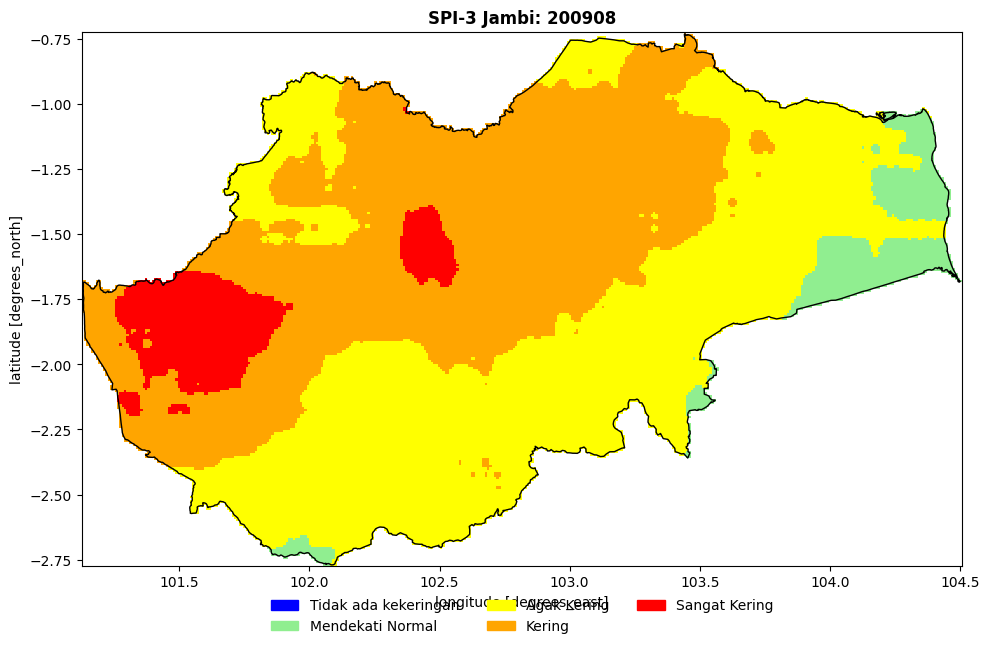

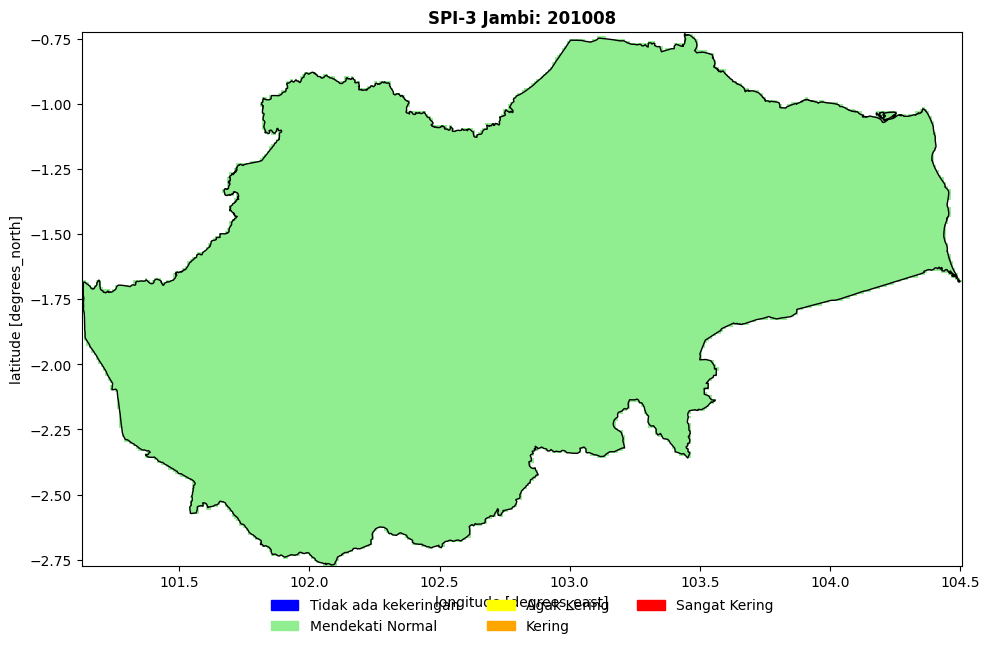

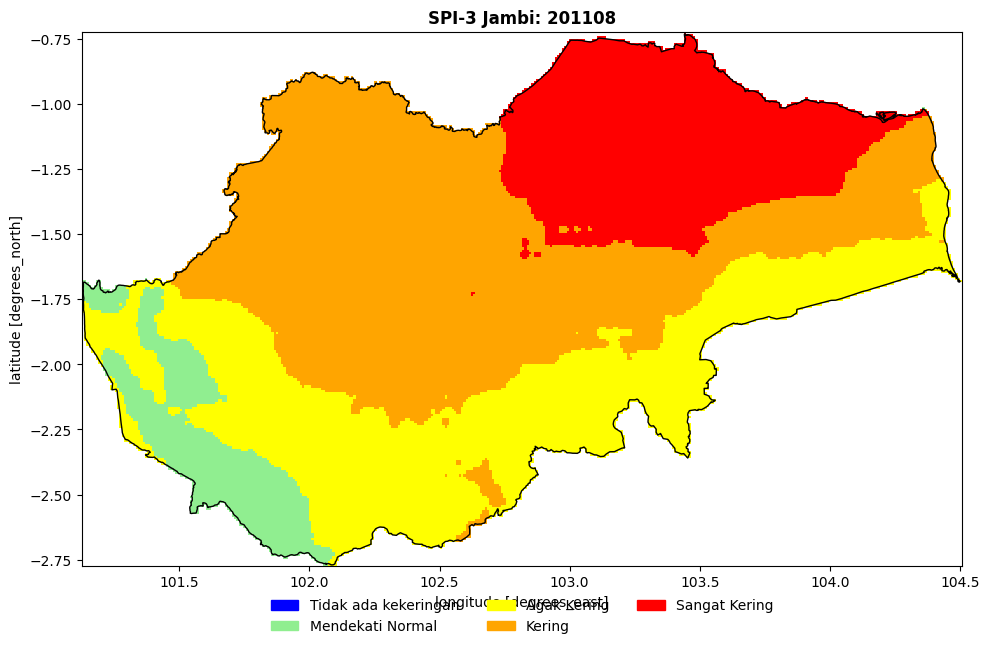

[SELESAI] Periode 2009-2011 tersimpan.

MEMPROSES SPI-3: 2012-2013
(Memuat buffer dari tahun 2011 agar awal tahun tidak kosong)
>> Memuat data CHIRPS dari tahun 2011 s.d 2013...
>> Menghitung SPI-3...
>> Memotong data ke periode target: 2012 s.d 2013
>> Menyimpan output...


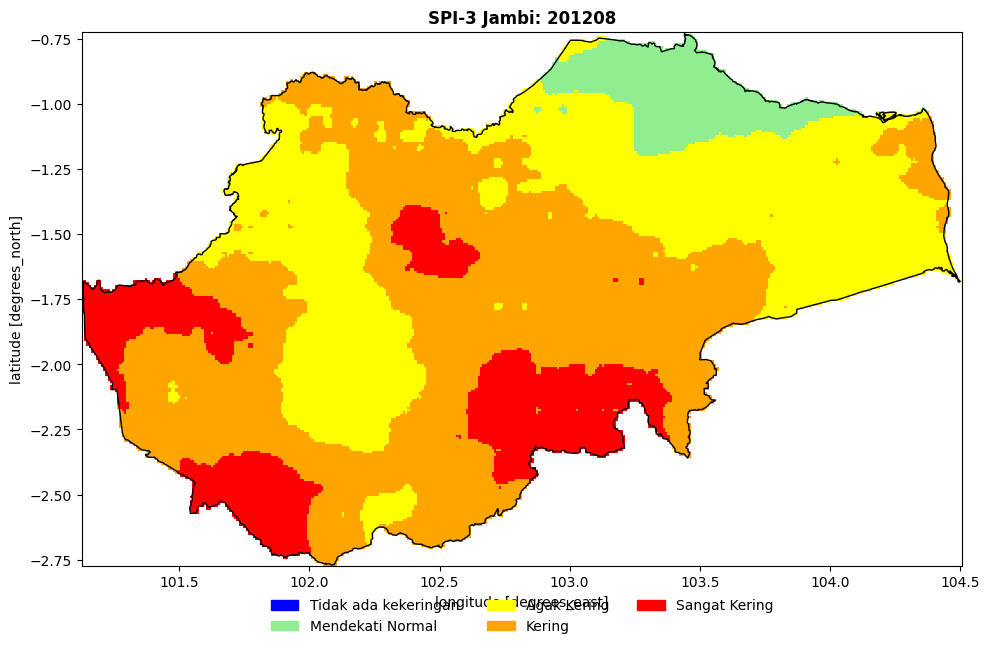

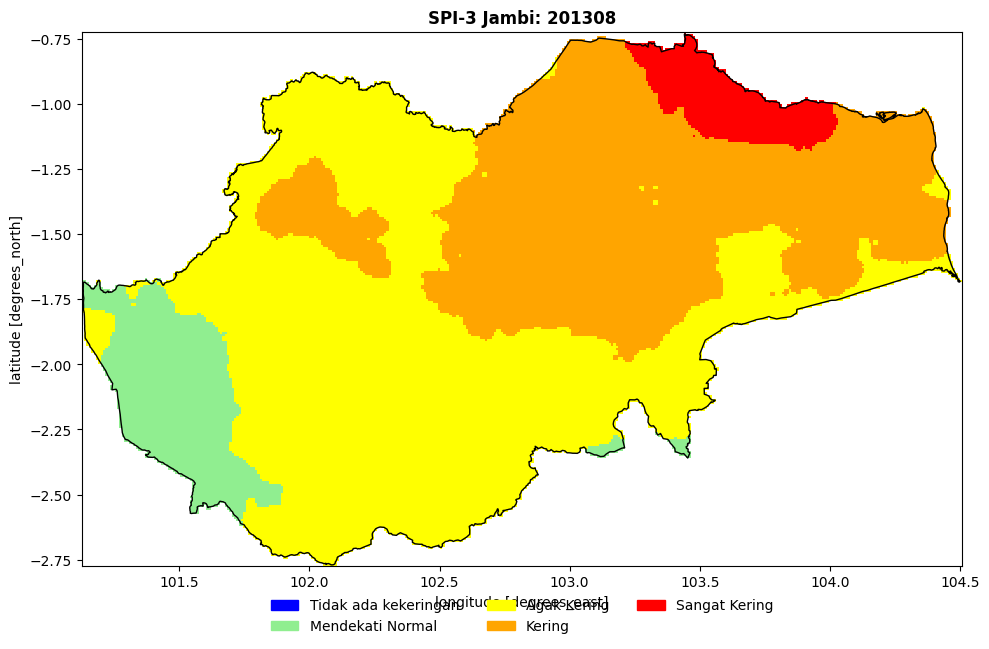

[SELESAI] Periode 2012-2013 tersimpan.

MEMPROSES SPI-3: 2014-2015
(Memuat buffer dari tahun 2013 agar awal tahun tidak kosong)
>> Memuat data CHIRPS dari tahun 2013 s.d 2015...
>> Menghitung SPI-3...
>> Memotong data ke periode target: 2014 s.d 2015
>> Menyimpan output...


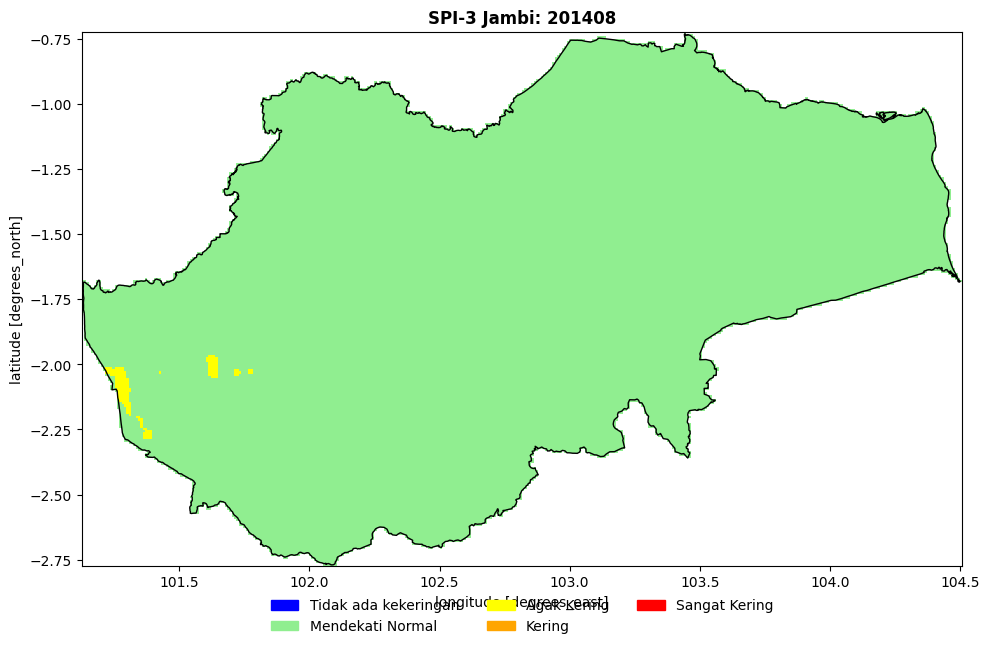

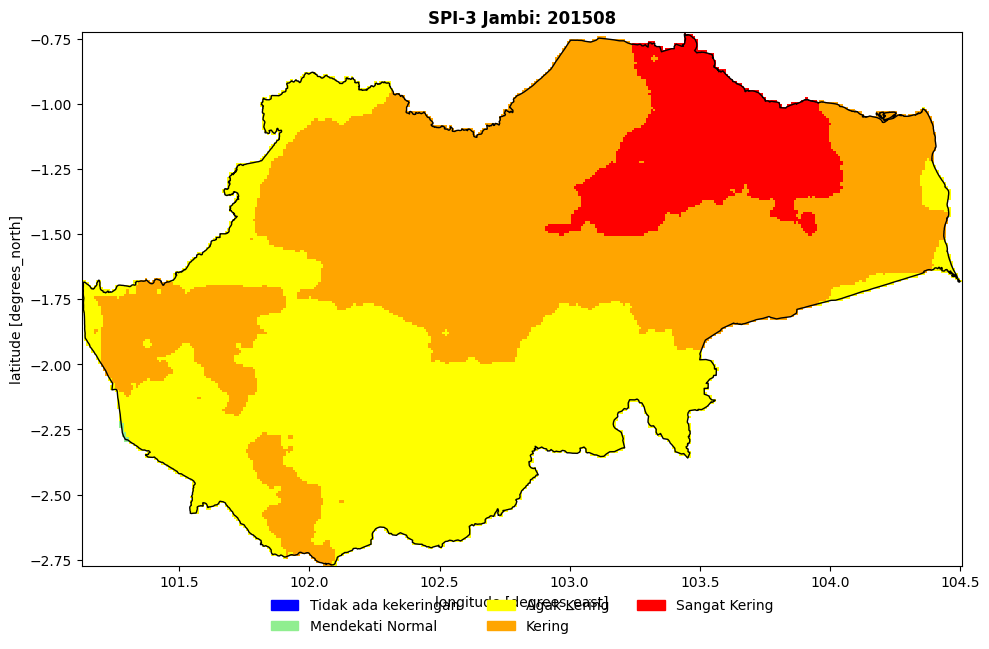

[SELESAI] Periode 2014-2015 tersimpan.

MEMPROSES SPI-3: 2016-2017
(Memuat buffer dari tahun 2015 agar awal tahun tidak kosong)
>> Memuat data CHIRPS dari tahun 2015 s.d 2017...
>> Menghitung SPI-3...
>> Memotong data ke periode target: 2016 s.d 2017
>> Menyimpan output...


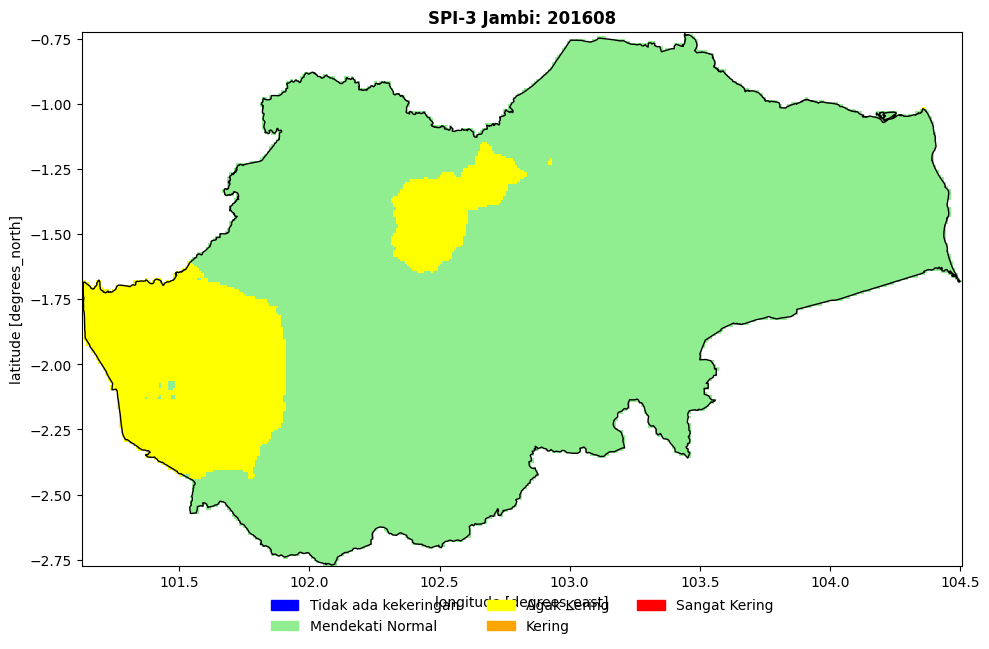

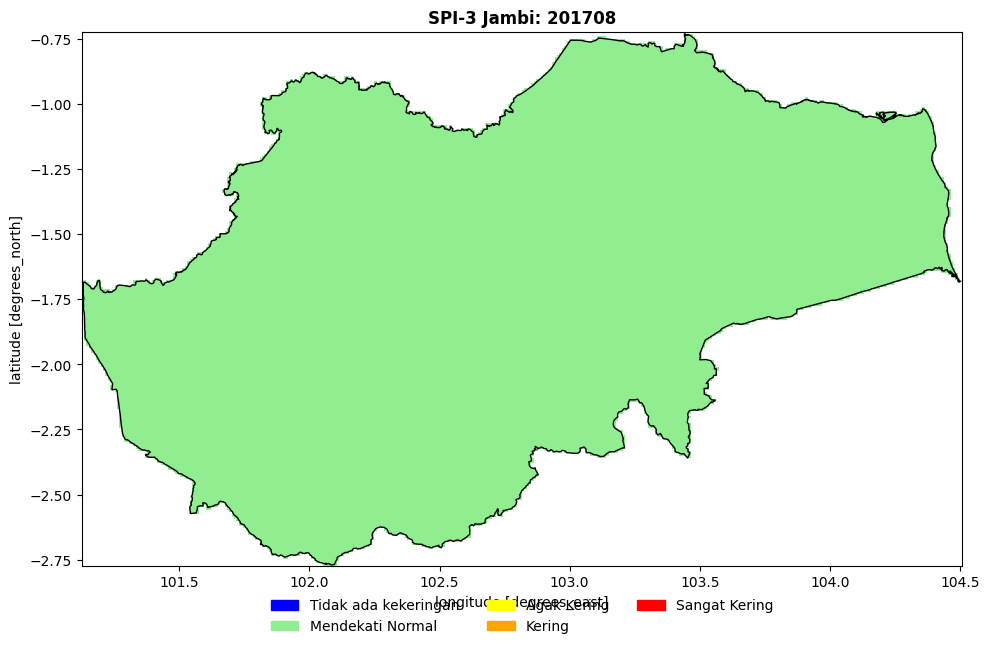

[SELESAI] Periode 2016-2017 tersimpan.

MEMPROSES SPI-3: 2018-2020
(Memuat buffer dari tahun 2017 agar awal tahun tidak kosong)
>> Memuat data CHIRPS dari tahun 2017 s.d 2020...
>> Menghitung SPI-3...
>> Memotong data ke periode target: 2018 s.d 2020
>> Menyimpan output...


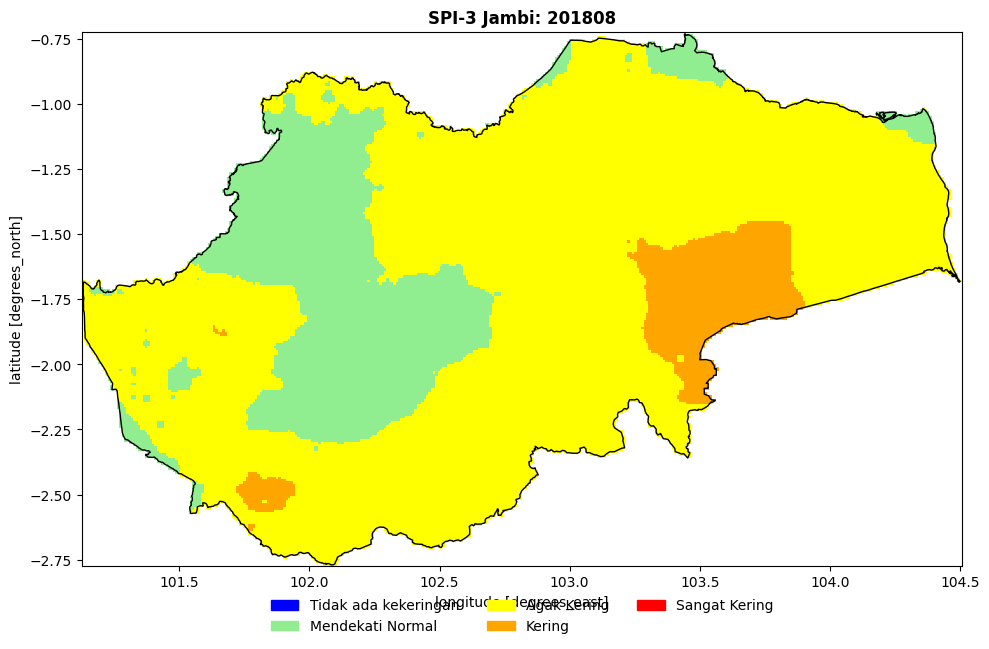

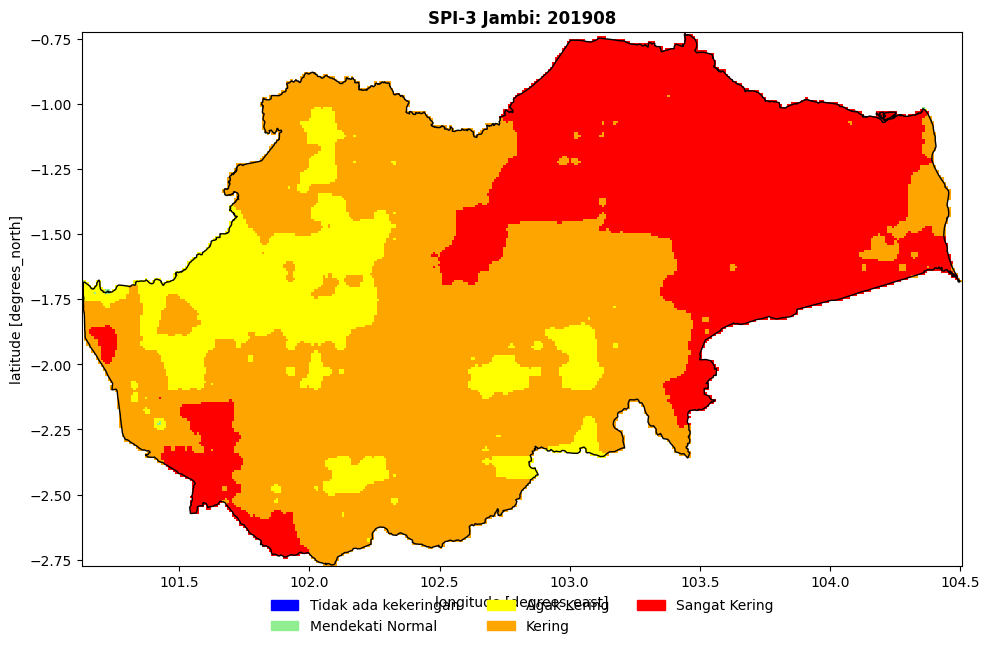

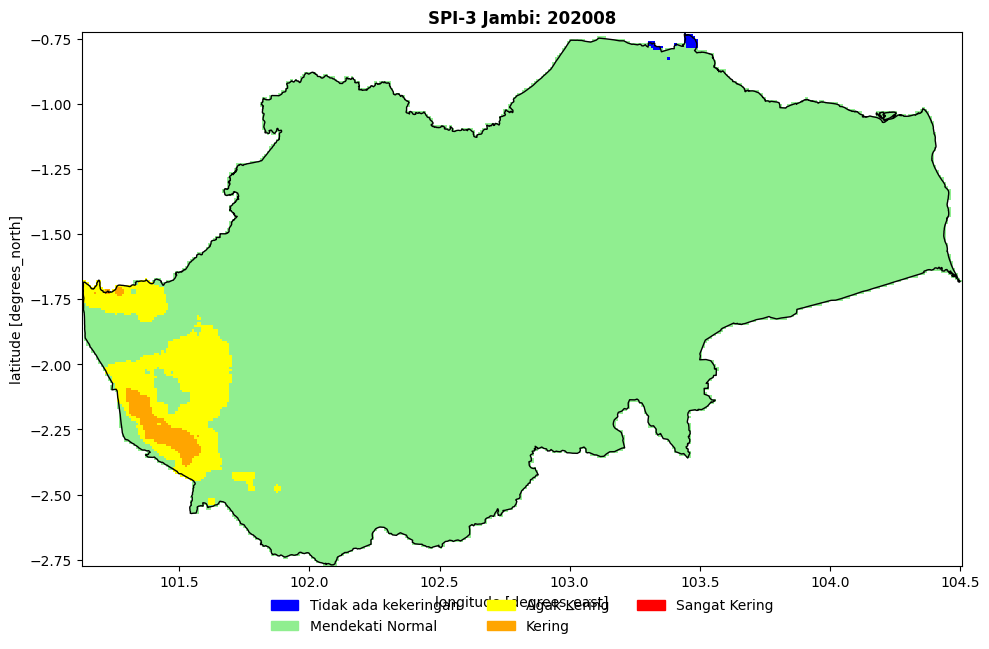

[SELESAI] Periode 2018-2020 tersimpan.


>>> SELURUH PROSES SELESAI <<<


In [ ]:
## 5. EKSEKUSI PROGRAM
# ------------------------------------------------------------------------------
if __name__ == '__main__':

    # PERUBAHAN DI SINI:
    # Gabungkan 2009 ke periode pertama.
    # Buffer akan mencoba mencari 2008. Karena 2008 tidak ada,
    # maka Jan-Feb 2009 akan kosong (NaN). TAPI, mulai Maret 2009 s.d. Des 2011 akan FULL.
    run_processing_period(2009, 2011)

    # Periode 2: 2012 - 2013 (Buffer 2011 ada -> AMAN)
    run_processing_period(2012, 2013)

    # Periode 3: 2014 - 2015
    run_processing_period(2014, 2015)

    # Periode 4: 2016 - 2017
    run_processing_period(2016, 2017)

    # Periode 5: 2018 - 2020
    run_processing_period(2018, 2020)

    print("\n\n>>> SELURUH PROSES SELESAI <<<")